In [1]:
# Import all the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib as mpl
import mpmath
from scipy.integrate import solve_ivp
from typing import List
from collections import Counter

# Parameters for plots
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# The SIR model

This project is focused on the SIR model, probably the most studied model in computational epidemics.

In particular the goal of the work is to simulate SIR model and try to reach the same results presented in:

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.   
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  


In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:

- **Susceptible** individuals (S): those who do not have the disease but can get it.
- **Infected** individuals (I) : those who have the disease.
- **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:

1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. Another assumption is that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


## Fully mixed population
If we assume a very large population that is **fully mixed**, it means that each node (individual) is connected with all the others, then the model can be described by a set of coupled nonlinear differential equations:  


<img src="SIR.png" width="350"> 

The first step of this work is to try to solve those differential equation using standard python libraries. I will use the function `solve_ivp` of `scipy.integrate`.

First I write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [2]:
def ode_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    S, I, R = y
    N = S + I + R
    f = np.array([
        - beta * (I / N) * S,
        beta * (I / N) * S - gamma * I,
        gamma * I,        
    ])
    return f

Use `solve_ivp` and `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters.

In [3]:
# set parameters
beta = 0.8
gamma = 0.2
y0 = (990, 10, 0) #initial values for S, I and R
tmax = 40

In [4]:
# solve ODE
ode_result = solve_ivp(ode_SIR, (0, tmax), y0, max_step=0.1)

In [5]:
# extract results
assert ode_result.success # to be sure the solver reached the interval end
t_range = ode_result.t
S, I, R = ode_result.y

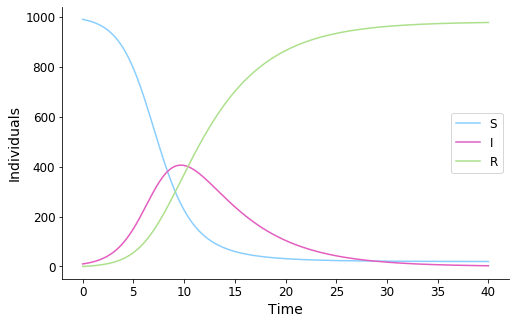

In [6]:
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(t_range, S, label="S", color=SIR_colors["S"])
ax.plot(t_range, I, label="I", color=SIR_colors["I"])
ax.plot(t_range, R, label="R", color=SIR_colors["R"])
ax.set_ylabel("Individuals")
ax.set_xlabel("Time")
ax.legend();

We can observe continuous decrease of the susceptible individuals and an increasing number of infected in the first period. After reaching a maximum the infected curve start to decrease and we can observe an increase of recovered individuals.

## SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures is what makes the whole thing much more difficult.

To explore the importance of the **contact network** for the spread of a disease, it is necessary to implement a discrete-time SIR model that runs on an arbitrary network or graph. To do so, I will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** that implement the SIR dynamics.

I will use the `networkx` module, a well-known python library to work with networks data.

### The SIR model as a python class

I will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and methods, and is exactly what is needed in this case: a network and some functions that implement the SIR dynamics on it.

`SIRonGraph` need different methods to work properly.

**1) `__init__`:**

The input to create a new SIR model on an arbitrary network is the following:

- The graph onto which we want to run the SIR model
- A list of initially infected nodes
- The coefficient $\beta$
- The coefficient $\gamma$

But it is necessary to be aware to:

- Checking that $\beta$ and $\gamma$ have sensible values
- Making sure that all elements in input list of inital infected are really nodes of the network
- Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

Furthemore if the goal is to analize the dynamics on the network an history is needed and it will be updated in `_log` method.

### SIR dynamics as class methods
Now I want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, let's consider **discrete time** simulation, so that at each time-step:

- Infected individuals have a chance to recover, and they do so with probability $\gamma$
- Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge

The two methods that allow to evolve the system are

**2) `_step`:**

This method implements one single time-step, as descrived above.

**3) `run`:**

This method simply calls `_step` repeately and update the history (see method 4).

### Storing SIR evolution as a class attribute
Now the class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is to create another method:

**4) `_log`:**

When called, computes the information we want to store and adds it to the self.history list.

In [7]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert (set(initial_infected).issubset(network.nodes))
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for node in initial_infected:
            network.nodes[node]["kind"] = "I"

        # make sure params make sense 
        assert ((0 <= beta <= 1) and (0 <= gamma <= 1))

        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        S = len(network) - len(initial_infected)
        I = len(initial_infected)
        R = 0
        info = [S, I, R]
        self.history.append(info)
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                if np.random.uniform() < self.gamma:
                    self.network.nodes[node]["kind"] = "R"
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            x, y = edge
            kind_x, kind_y = self.network.nodes[x]["kind"], self.network.nodes[y]["kind"]
            if kind_x == "S" and kind_y == "I":
                if np.random.uniform() < self.beta:
                    self.network.nodes[x]["kind"] = "I"
            if kind_x == "I" and kind_y == "S":
                if np.random.uniform() < self.beta:
                    self.network.nodes[y]["kind"] = "I"
        
    def _log(self):
        """Store network state."""
        S = 0
        I = 0
        R = 0
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                S += 1
            if self.network.nodes[node]["kind"] == "I":
                I += 1
            if self.network.nodes[node]["kind"] == "R":
                R += 1
        info = [S, I, R]
        self.history.append(info)
        

### Visualize the network

Here I implemented a function that allow to visualize the network and its evolution over time.

In [8]:
def show_model(model, ax=None):
    # creates a figure if no axis was passed
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()       

    # get the positions and kind of nodes
    pos = nx.get_node_attributes(model.network, 'pos')
    kinds = nx.get_node_attributes(model.network, 'kind')

    # prepare a list of colors for the nodes using the kinds dict
    node_color = {
        "S": "#8aceff",
        "I": "#e35dbf",
        "R": "#ace08b"
    }

    # draw the network
    nx.draw_networkx(model.network,
                     ax = ax,
                     pos = pos,
                     labels = kinds,
                     node_color = [node_color[model.network.nodes[node]['kind']] for node in model.network.nodes])
    
    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

Let's use a standard hexagonal graph of networkx library to test the function.

/Users/eleonoragatti/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


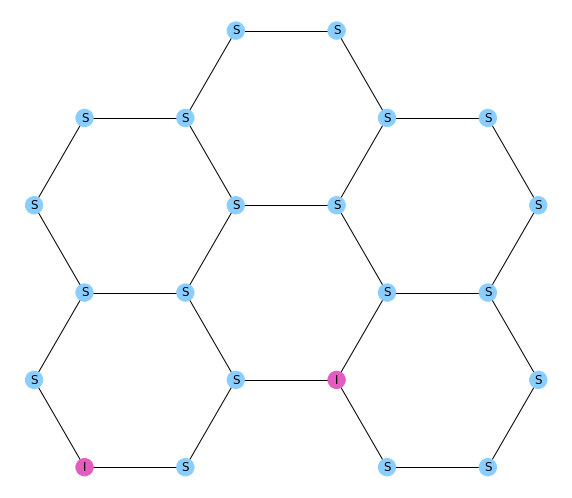

In [9]:
G = nx.hexagonal_lattice_graph(2, 3)

net = SIRonGraph(network = G, initial_infected = [(0,0), (2,1)], beta = 0.8, gamma = 0.1)
show_model(net);

To be sure that the class is working correctly is possible to show the evolution of a SIR model running in a hexagonal lattice.

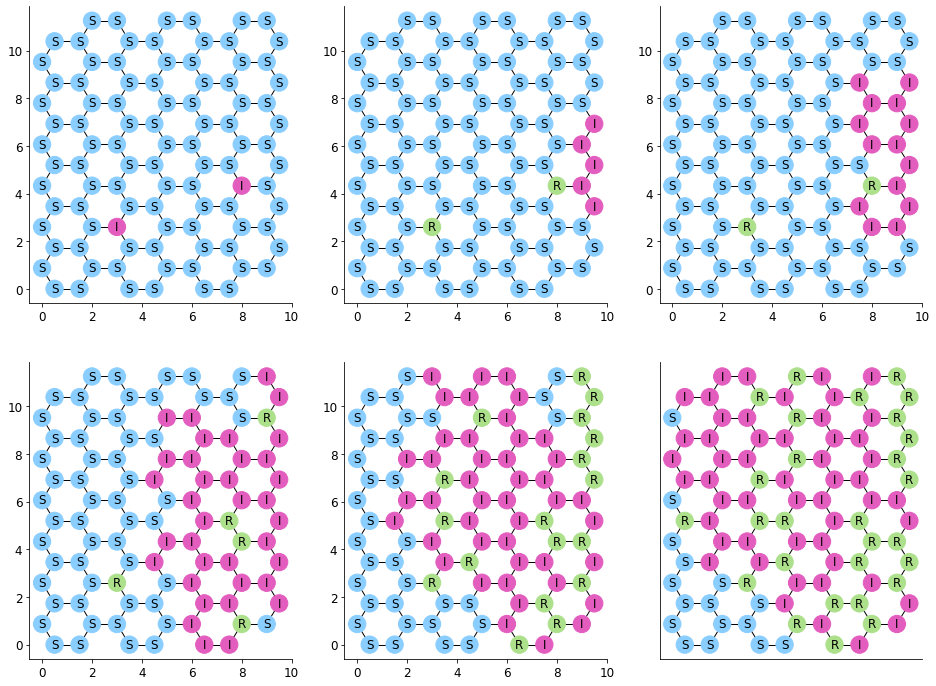

In [10]:
G = nx.hexagonal_lattice_graph(6, 6)
model = SIRonGraph(network=G, initial_infected=[(2, 3),(5, 5)], beta=0.3, gamma=0.05)

fig, axx = plt.subplots(2, 3, figsize=(16, 12))
axx = axx.reshape(-1)

for ax in axx:
    ### plot model status on axis ax
    show_model(model, ax)
    
    ### run the model for some timesteps
    model.run(5)

### Simulate SIR on graph

Is now possible to simulate the SIR model on a network and plot the evolution of the system (S, I, R) over time.

In [11]:
# create the model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.3,
    gamma=0.05
)

# run the model for some time
num_timesteps = 500

model.run(num_timesteps)

In [12]:
# extract evolution of S, I, R from model.history

S_evol = np.array(model.history)[:,0]
I_evol = np.array(model.history)[:,1]
R_evol = np.array(model.history)[:,2]

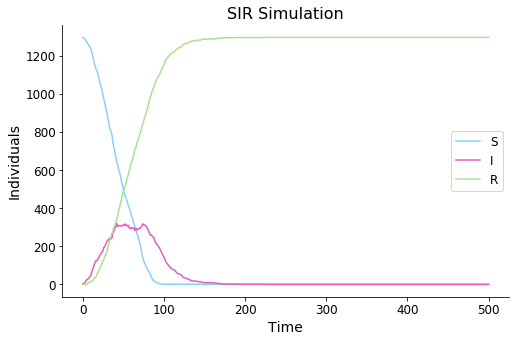

In [13]:
# plot S,I,R vs time
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

#time = np.arange(num_timesteps)

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(S_evol, label="S", color=SIR_colors["S"])
ax.plot(I_evol, label="I", color=SIR_colors["I"])
ax.plot(R_evol, label="R", color=SIR_colors["R"])
ax.set_xlabel("Time")
ax.set_ylabel("Individuals")
ax.set_title("SIR Simulation")
ax.legend();

## Comparison between ODE and `SIRonGraph`

It can be interesting to compare the results obtained by the simulation with `SIRonGraph` and the ones given by the resolution of the differential equation of the first part of the notebook. This is possible but it is necessary to use a fully connected network, i.e. a complete graph.

I will use a complete graph with 800 nodes: `nx.complete_graph(800)`.

In [14]:
beta = 0.8
gamma = 0.05
y0 = (797, 3, 0)
tmax = 50

#solve ODE
ode_result = solve_ivp(ode_SIR, (0, tmax), y0, max_step=0.1)
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

In [15]:
# define the model
model = SIRonGraph(
    network=nx.complete_graph(800),
    initial_infected=[44, 50, 73],
    beta=0.8/800,
    gamma=0.05
)

In [16]:
%%time

# run the model, extrarct results
num_timesteps = 50
model.run(num_timesteps)

S_evol = np.array(model.history)[:,0]
I_evol = np.array(model.history)[:,1]
R_evol = np.array(model.history)[:,2]

CPU times: user 45.5 s, sys: 403 ms, total: 46 s
Wall time: 49.8 s


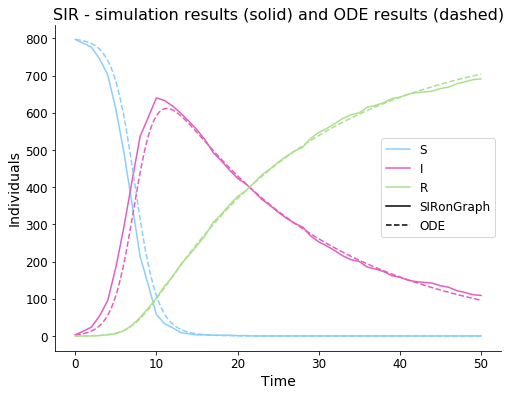

In [17]:
# plot results togetherr with old ODE results
#time = np.arange(num_timesteps)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
line = []
# plot simulation results
ax.plot(S_evol, label="S", color=SIR_colors["S"])
ax.plot(I_evol, label="I", color=SIR_colors["I"])
ax.plot(R_evol, label="R", color=SIR_colors["R"])

# plot ODE results
ax.plot(t_range, S, color=SIR_colors["S"], linestyle='dashed')
ax.plot(t_range, I, color=SIR_colors["I"], linestyle='dashed')
ax.plot(t_range, R, color=SIR_colors["R"], linestyle='dashed')
ax.set_xlabel("Time")
ax.set_ylabel("Individuals")
ax.plot([], color='black', label='SIRonGraph')
ax.plot([], color='black', label='ODE', linestyle='dashed')
ax.legend();
ax.set_title("SIR - simulation results (solid) and ODE results (dashed)");

**Observe:**

Starting with a low number of initial infected the evolution of the epidemic strongly depends on the behavior of those individuals. It can happens that if they infect others in the first step the evolution of the simulation start earlier than the solution of the ODE otherwise it starts later. This fact causes a little shift between the two curves. When the number of infected gets bigger the trend of the two curves appears to be the same.

# The spread of epidemic disease on networks

As Newman says in his paper, epidemic behavior usually shows a phase transition with the parameters of the model a sudden transition from a regime without epidemics to one with. The crucial element in this case is the **topology** of the network. It is obvious that a given infective individual does not have equal probability of infecting all others; in the real world each individual only has contact with a small fraction of the total population, although the number of contacts that people have can vary greatly from one person to another.

The next step of this work is to verify that the **epidemic size** exhibits a **phase transition** (i.e. presents critical transmission) and that the value of the **critical trasmission** is a function of the degree distribution of the network.

<img src="Newman.png" width="600"> 

Here the tree different lines correspond to different values of the degree distribution of the network.

### Compute Trasmissibility

The transmissibility $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

If we considere a discrate-time model we can write it in term of parameters $\beta$ and $\gamma$:

$$
T = 1 - \gamma \sum_{\tau=0}^{\infty} (1-\gamma)^{\tau} (1-\beta)^{\tau} = 1 - \frac{\gamma}{1-(1-\beta)(1-\gamma)}
$$

To compute the transmissibility $T$ numerically I will add another method to `SIRonGraph` class.

In [18]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert (set(initial_infected).issubset(network.nodes))
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for node in initial_infected:
            network.nodes[node]["kind"] = "I"

        # make sure params make sense 
        assert ((0 <= beta <= 1) and (0 <= gamma <= 1))

        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        S = len(network) - len(initial_infected)
        I = len(initial_infected)
        R = 0
        info = [S, I, R]
        self.history.append(info)
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                if np.random.uniform() < self.gamma:
                    self.network.nodes[node]["kind"] = "R"
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            x, y = edge
            kind_x, kind_y = self.network.nodes[x]["kind"], self.network.nodes[y]["kind"]
            if kind_x == "S" and kind_y == "I":
                if np.random.uniform() < self.beta:
                    self.network.nodes[x]["kind"] = "I"
            if kind_x == "I" and kind_y == "S":
                if np.random.uniform() < self.beta:
                    self.network.nodes[y]["kind"] = "I"
        
    def _log(self):
        """Store network state."""
        S = 0
        I = 0
        R = 0
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                S += 1
            if self.network.nodes[node]["kind"] == "I":
                I += 1
            if self.network.nodes[node]["kind"] == "R":
                R += 1
        info = [S, I, R]
        self.history.append(info)
    
    
    def get_transmissibility(self):
        """Compute trasmissibility."""
        T = 1 - self.gamma/(1 - (1 - self.gamma)*(1 - self.beta))
        return T


## The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. I will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature.

In order to study the total size of an epidemic is more convinient to add a new method (`run_till_end`) that runs a simulation until no more infected individuals are left.

In [19]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        assert (set(initial_infected).issubset(network.nodes))
            
        # set initial status of nodes as node att
        nx.set_node_attributes(network, "S", name="kind")
        for node in initial_infected:
            network.nodes[node]["kind"] = "I"

        # make sure params make sense 
        assert ((0 <= beta <= 1) and (0 <= gamma <= 1))

        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma
    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        S = len(network) - len(initial_infected)
        I = len(initial_infected)
        R = 0
        info = [S, I, R]
        self.history.append(info)
        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for _ in range(num_timesteps):
            self._step()
            self._log()
    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "I":
                if np.random.uniform() < self.gamma:
                    self.network.nodes[node]["kind"] = "R"
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            x, y = edge
            kind_x, kind_y = self.network.nodes[x]["kind"], self.network.nodes[y]["kind"]
            if kind_x == "S" and kind_y == "I":
                if np.random.uniform() < self.beta:
                    self.network.nodes[x]["kind"] = "I"
            if kind_x == "I" and kind_y == "S":
                if np.random.uniform() < self.beta:
                    self.network.nodes[y]["kind"] = "I"
        
    def _log(self):
        """Store network state."""
        S = 0
        I = 0
        R = 0
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"] == "S":
                S += 1
            if self.network.nodes[node]["kind"] == "I":
                I += 1
            if self.network.nodes[node]["kind"] == "R":
                R += 1
        info = [S, I, R]
        self.history.append(info)
    
    def get_transmissibility(self):
        """Compute trasmissibility."""
        T = 1 - self.gamma/(1 - (1 - self.gamma)*(1 - self.beta))
        return T
    
    def run_till_end(self):
        """Run the simulation until no more infected individuals are left."""
        while ('I' in nx.get_node_attributes(self.network, "kind").values()):
            self._step()
            self._log()


## Generating realistic networks
To reproduce the plot shown above is necessary to generate networks with a certain distrirbution given by: 

<img src="P_k.png" width="400">


Using the `nx.configuration_model` function, is possible to generate a network with an arbitrary degree sequence.


The following functions generate networks with degree distribution as defined in the paper.

In [20]:
"""
Taken from:
Francesc Font-Clos, Statistical Mechanics, University of Milan

and slightly modified by
Eleonora Gatti,
July 2020
"""

def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa, 
    as defined in Newman's paper, Equation 30.
    """
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

Now that the power law is defined it is necessary to sample from it.

In [21]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman's paper, Equation 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [22]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

## Simulation and Results

In order to obtain a plot similar to Newman's one, is essential to take the proper measures:

- Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8].
- Define a function that takes parameters as input and returns epidemic size.
- Do the simulation for different value of the parameter $\kappa$. I will use the same of the paper: 5, 10, 20

In [23]:
# choose ranges of parameters

betas = [0.01, 0.03, 0.05, 0.08, 0.15, 0.2, 0.35, 0.4, 0.7, 0.99]
kappas = [5, 10, 20]
gamma = 0.2
N = 500 # n of nodes

In [24]:
def get_epidemic_df(N: int, kappas, betas, gamma):
    data = []
    for k in kappas:
        for beta in betas:    
            G = get_newman_network(N=N, alpha=2, kappa=k)
            model = SIRonGraph(
                network=G,
                initial_infected=[np.random.randint(N)],
                beta=beta,
                gamma=gamma
            )
            model.run_till_end()
            outbreak_size = model.history[-1][2]

            data.append({
                "S": outbreak_size/len(G),
                "T": model.get_transmissibility(),
                "k": k
            })
        #print(k, end="\r")
    df = pd.DataFrame(data)
    return df


In [25]:
%%time

# iterate over parameter ranges
# and store results

iterations = 150

data_for_plot = pd.DataFrame(columns = ['T', 'S', 'k'])
start = get_epidemic_df(N, kappas, betas, gamma)

data_for_plot['T'] = start['T']
data_for_plot['S'] = start['S']
data_for_plot['k'] = start['k']

for i in range(iterations):
    print(i, end="\r")
    data_for_plot['S'] += get_epidemic_df(N, kappas, betas, gamma)['S']

data_for_plot['S'] = data_for_plot['S']/(iterations + 1)

CPU times: user 30min 9s, sys: 8.43 s, total: 30min 17s
Wall time: 31min 12s


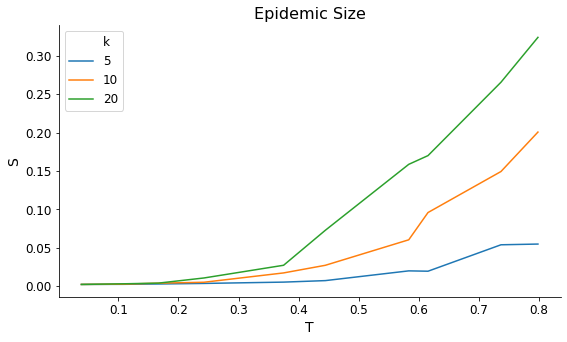

In [26]:
# plot the results

palette = sns.color_palette(n_colors=3)
fig, ax = plt.subplots(1, 1, figsize=(9,5))
sns.lineplot(data=data_for_plot, x="T", y="S", hue="k", palette=palette, ax=ax)
ax.set_title("Epidemic Size");
plt.savefig('Result.pdf', dpi=400)

For reasons of computational time the network used for the simulation is smaller than the one used by Newman. Nevertheless we can approximately observe three different critical trasmissibility:

- *$T_c \approx 0.2$ for $\kappa=20$*
- *$T_c \approx 0.4$ for $\kappa=10$*
- *$T_c \approx 0.6$ for $\kappa=5$* 

The results obtained with the simulation are similar to those of the paper as expected.

**Observe:**

The parameter $\kappa$ tell us the numbers of contacts between people. In the limit $\kappa\rightarrow\infty$ everyone has the same number of contacts. When $\kappa$ decreases there are fewer people who has lots of contacts (**super-spreaders**) but most people have a small numbers of contacts. This means that when $\kappa$ increases there are more contacts between individuals and critical transmissibility is achieved faster.

Therfore is possible to see that, in this semplified model, the only way to stop the spread of an epidemic is to decrease the value of $\kappa$, i.e. ask people to stay at home and do not ineract directly with each other.